 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Customer_ID           500 non-null    object 
 1   Age                   500 non-null    int64  
 2   Income                461 non-null    float64
 3   Credit_Score          498 non-null    float64
 4   Credit_Utilization    500 non-null    float64
 5   Missed_Payments       500 non-null    int64  
 6   Delinquent_Account    500 non-null    int64  
 7   Loan_Balance          471 non-null    float64
 8   Debt_to_Income_Ratio  500 non-null    float64
 9   Employment_Status     500 non-null    object 
 10  Account_Tenure        500 non-null    int64  
 11  Credit_Card_Type      500 non-null    object 
 12  Location              500 non-null    object 
 13  Month_1               500 non-null    object 
 14  Month_2               500 non-null    object 
 15  Month_3 

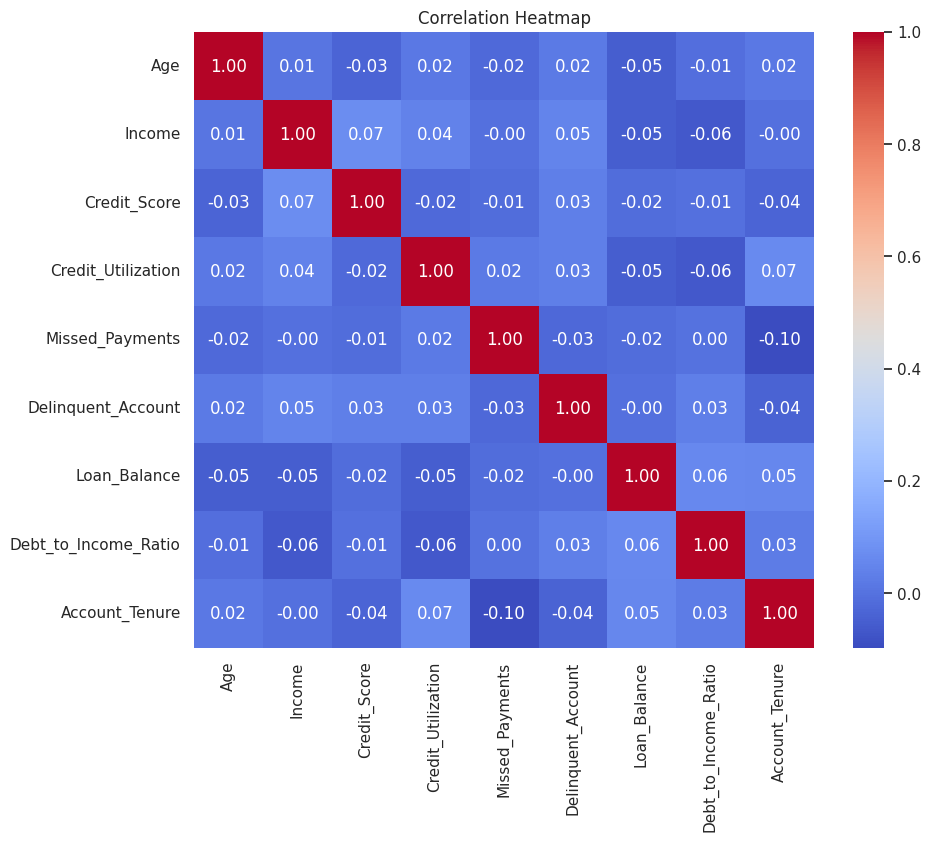

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_excel("Delinquency.xlsx", sheet_name="Sheet1")

# Set plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# 1. Check basic info
print(" Dataset Info:")
print(df.info())

# 2. Missing values
print("\n Missing Values:")
print(df.isnull().sum())

# 3. Target Distribution
print("\n Target Distribution:")
print(df['Delinquent_Account'].value_counts())

# 4. Summary statistics
print("\n Summary Statistics:")
print(df.describe())

# 5. Correlation Matrix for numeric variables
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Step 1: Encode categorical variables
categorical_cols = ['Employment_Status', 'Credit_Card_Type', 'Location']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Optional Step 2: Convert Payment History (Month_1 to Month_6) to numerical score
def encode_payment(val):
    if val == "On-time":
        return 0
    elif val == "Late":
        return 1
    elif val == "Missed":
        return 2
    else:
        return -1  # Handle unexpected cases

for col in ['Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6']:
    df[col] = df[col].apply(encode_payment)

# Create a new feature: average payment score across 6 months
df['Avg_Payment_Behavior'] = df[['Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6']].mean(axis=1)

# Drop raw Month columns if not needed anymore
df.drop(columns=['Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6'], inplace=True)

# Step 3: Define features (X) and target (y)
X = df.drop(columns=['Delinquent_Account'])
y = df['Delinquent_Account']

#  Drop identifier column if present
if 'Customer_ID' in X.columns:
    X = X.drop(columns=['Customer_ID'])

y = df['Delinquent_Account']

#  Handle missing values
# Fill all NaNs with column means
X = X.fillna(X.mean())

# Step 4: Scale numeric features
numeric_cols = X.select_dtypes(include='number').columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])


sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# Final train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)


In [3]:
import numpy as np
unique, counts = np.unique(y_resampled, return_counts=True)
print("Resampled Class Distribution:", dict(zip(unique, counts)))


Resampled Class Distribution: {np.int64(0): np.int64(420), np.int64(1): np.int64(420)}


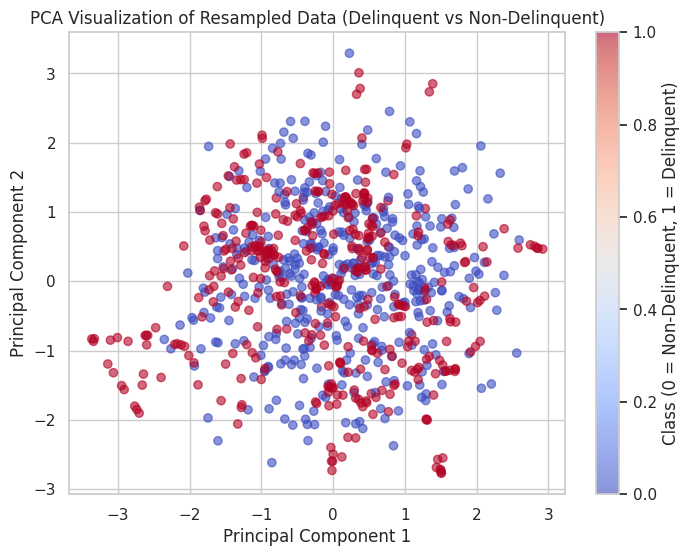

Preprocessing complete. Shape of training data: (672, 12)


In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_resampled, cmap='coolwarm', alpha=0.6)
plt.title("PCA Visualization of Resampled Data (Delinquent vs Non-Delinquent)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.colorbar(label="Class (0 = Non-Delinquent, 1 = Delinquent)")
plt.show()

# Then continue as usual:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

print("Preprocessing complete. Shape of training data:", X_train.shape)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1)


In [8]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Model training (only if not trained already)
logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Predictions
y_pred_logreg = logreg.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

# Evaluation function
def evaluate_model(name, y_true, y_pred):
    print(f"\n Model: {name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred, zero_division=0))

# Evaluate all models
evaluate_model("Logistic Regression", y_test, y_pred_logreg)
evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("XGBoost", y_test, y_pred_xgb)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:57:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Model: Logistic Regression
Accuracy: 0.5178571428571429
ROC AUC Score: 0.5178571428571429
Confusion Matrix:
 [[38 46]
 [35 49]]
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.45      0.48        84
           1       0.52      0.58      0.55        84

    accuracy                           0.52       168
   macro avg       0.52      0.52      0.52       168
weighted avg       0.52      0.52      0.52       168


 Model: Random Forest
Accuracy: 0.9047619047619048
ROC AUC Score: 0.9047619047619048
Confusion Matrix:
 [[79  5]
 [11 73]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91        84
           1       0.94      0.87      0.90        84

    accuracy                           0.90       168
   macro avg       0.91      0.90      0.90       168
weighted avg       0.91      0.90      0.90       168


 Model: XGBoost
Accuracy: 0.892857142857142

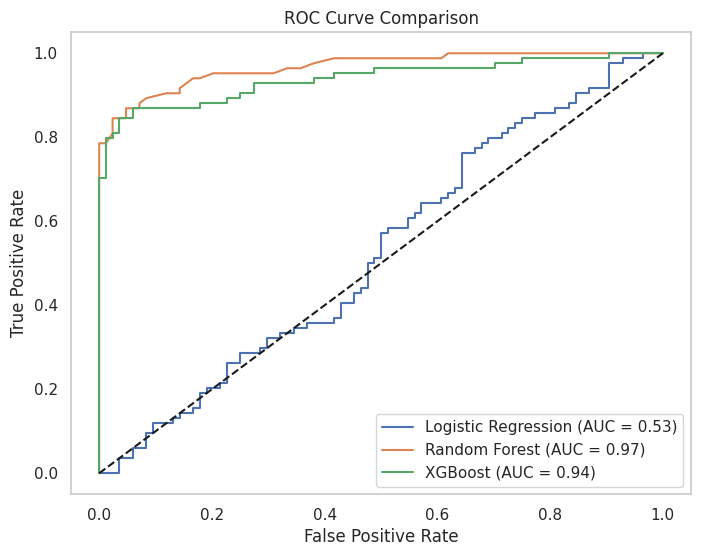

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

models = {'Logistic Regression': logreg, 'Random Forest': rf, 'XGBoost': xgb}

plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()
